# Robust and Stochastic Optimal Control

In [1]:
import os
import time
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal
import matplotlib.pyplot as plt
from casadi import (
    MX, SX, DM, Function, Opti, integrator,
    vcat, hcat, vertcat, horzcat, vec, diag, reshape,
    dot, sum1, sum2, sumsqr, sin, cos,
    gradient, jacobian, hessian
)

import casadi
casadi.__version__

'3.6.5'

In [2]:
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

In [3]:
# Physical constants

T = 1.0  # control horizon [s]
N = 40  # Number of control intervals

dt = T / N  # length of 1 control interval [s]

tgrid = np.linspace(0, T, N+1)
tgrid.shape

(41,)

## Continuous system $\dot{x}=f(x,u)$

Van der Pol oscillator

$$
\frac{d\left[\begin{array}{l}
x_1 \\
x_2
\end{array}\right]}{d t}=\left[\begin{array}{c}
x_2 \\
-0.1\left(1-x_1^2\right) x_2-x_1+u
\end{array}\right]
$$

In [4]:
nx = 2

# Expression for the ODE right-hand side
x1 = MX.sym('x1')
x2 = MX.sym('x2')
u = MX.sym('u')
x = vertcat(x1, x2)
rhs = vertcat(x2, -0.1 * (1 - x1**2) * x2 - x1 + u)

# Upper bound on first state variable
x1_bound = lambda t: 2 + 0.1 * cos(10 * t)

## Discrete system $x_{k+1} = F(x_k,u_k)$

In [5]:
intg = integrator('intg', 'cvodes', {'x': x, 'p': u, 'ode': rhs}, 0, dt)

## 1. Stochastic optimal control

\begin{array}{cl}
\underset{x(\cdot), u(\cdot)}{\operatorname{minimize}} & \int_0^T\left\|x_1(t)-3\right\|_2^2 d t \\
\text { subject to } & \dot{x}(t)=f(x(t), u(t)) \quad \forall t \in[0, T] \\
& -40 \leq u(t) \leq 40 \quad \forall t \in[0, T] \\
& -0.25 \leq x_1(t) \leq b(t) \quad \forall t \in[0, T] \\
& x(0)=\hat{x}
\end{array}

### Template code – Optimal control problem, multiple shooting

In [6]:
x0 = vertcat(0.5, 0)

opti = casadi.Opti()

# Decision variable for states
x = opti.variable(nx)

# Initial constraints
opti.subject_to(x == x0)

U = []
X = [x]

# Gap-closing shooting constraints
for k in range(N):
  u = opti.variable()
  U.append(u)

  x_next = opti.variable(nx)
  res = intg(x0=x, p=u)
  opti.subject_to(x_next == res["xf"])

  opti.subject_to(opti.bounded(-40, u, 40))
  opti.subject_to(opti.bounded(-0.25, x[0], x1_bound(tgrid[k])))
  
  x = x_next
  X.append(x)

opti.subject_to(opti.bounded(-0.25, x_next[0], x1_bound(tgrid[N])))
U = hcat(U)
X = hcat(X)

opti.minimize(sumsqr(X[0, :] - 3))

opti.solver('ipopt')

sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      322
Number of nonzeros in inequality constraint Jacobian.:       81
Number of nonzeros in Lagrangian Hessian.............:      241

Total number of variables............................:      122
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       82
Total number of inequality c

### Post-processing: plotting

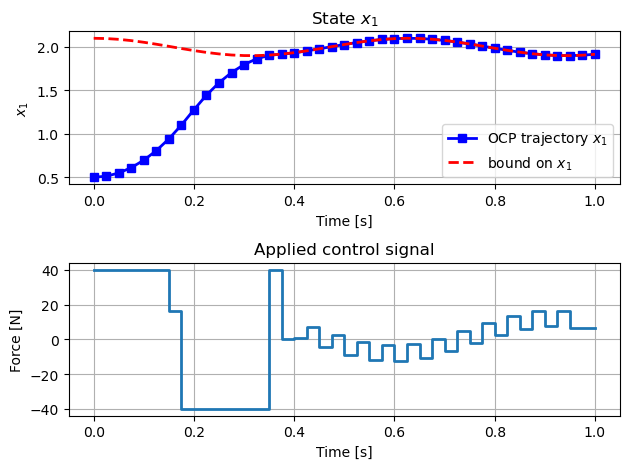

In [7]:
def make_ioplot(tgrid, xsol, usol):
    fig, axes = plt.subplots(2, 1)
    
    ax = axes[0]
    ax.plot(tgrid, xsol[0, :].T, 'bs-', linewidth=2)
    ax.plot(tgrid, x1_bound(tgrid), 'r--', linewidth=2)
    ax.set_title('State $x_1$')
    ax.legend(('OCP trajectory $x_1$', 'bound on $x_1$'))
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('$x_1$')
    ax.grid()
    
    ax = axes[1]
    ax.step(tgrid, vertcat(usol, usol[-1]), linewidth=2)
    ax.set_title('Applied control signal')
    ax.set_ylabel('Force [N]')
    ax.set_xlabel('Time [s]')
    ax.grid()

    return fig, axes

usol = sol.value(U)
xsol = sol.value(X)
make_ioplot(tgrid, xsol, usol)
plt.tight_layout()
filename = "robust_sol_1_1_0_ioplot.pdf"
plt.savefig(os.path.join(plot_dir, filename))
plt.show()

### 1.1. Augment the multiple-shooting implementation with the covariance dynamics

\begin{array}{cl}
\underset{x(\cdot), u(\cdot)}{\operatorname{minimize}} & \int_0^T\left\|x_1(t)-3\right\|_2^2 d t \\
\text { subject to } & \dot{x}(t)=f(x(t), u(t)) \quad \forall t \in[0, T] \\
& x(0)=\hat{x} \\
& \dot{\Sigma}_{x(t)}=\frac{\partial f}{\partial x}(x(t), u(t)) \Sigma_{x(t)}+\Sigma_{x(t)} \frac{\partial f^T}{\partial x}(x(t), u(t))+Q(t) \quad \forall t \in[0, T] \\
& \Sigma_{x(0)}=\Sigma_{\hat{x}} \\
& -40 \leq u(t) \leq 40 \quad \forall t \in[0, T] \\
& -0.25 \leq x_1(t) \leq b(t) \quad \forall t \in[0, T]
\end{array}

In [8]:
# Expression for the ODE right-hand side
x1 = MX.sym('x1')
x2 = MX.sym('x2')
u = MX.sym('u')
dxdt_rhs = vertcat(x2, -0.1 * (1 - x1**2) * x2 - x1 + u)
dxdt_rhs

MX(vertcat(x2, ((((-0.1*(1-sq(x1)))*x2)-x1)+u)))

In [9]:
x = vertcat(x1, x2)
dfdx = jacobian(dxdt_rhs, x)
dfdu = jacobian(dxdt_rhs, u)
assert dfdx.shape == (2, 2)
assert dfdu.shape == (2, 1)

In [10]:
# Expression for propagating the covariance matrix
P = MX.sym('sigma_x', 2, 2)
dPdt_rhs = dfdx @ P + P @ dfdx.T
assert dPdt_rhs.shape == (2, 2)

In [11]:
rhs = vertcat(dxdt_rhs, vec(dPdt_rhs))
x_aug = vertcat(x, vec(P))
assert rhs.shape == (6, 1)
assert x_aug.shape == (6, 1)

In [12]:
x1_bound = lambda t: 2 + 0.1 * cos(10 * t)

In [13]:
intg = integrator('intg', 'cvodes', {'x': x_aug, 'p': u, 'ode': rhs}, 0, dt)
intg

Function(intg:(x0[6],z0[0],p,u[0],adj_xf[],adj_zf[],adj_qf[])->(xf[6],zf[0],qf[0],adj_x0[],adj_z0[],adj_p[],adj_u[]) CvodesInterface)

In [14]:
# Initial condition is defined by a Gaussian distribution
x0 = vertcat(0.5, 0)

### Optimal control problem, multiple shooting

In [15]:
opti = casadi.Opti()

# Decision variable for states
x = opti.variable(nx)
P = opti.variable(nx, nx)

# Initial constraints
opti.subject_to(x == x0)
opti.subject_to(P == diag([0.01**2, 0.1**2]))

U = []
X = [x]
Ps = [P]
# Gap-closing shooting constraints
for k in range(N):
    u = opti.variable()
    U.append(u)

    x_next = opti.variable(nx)
    P_next = opti.variable(nx, nx)
    res = intg(x0=vertcat(x, vec(P)), p=u)

    xf = res["xf"][:nx]
    Pf = reshape(res["xf"][nx:], nx, nx)
    opti.subject_to(x_next == xf)
    opti.subject_to(vec(P_next) == vec(Pf))

    opti.subject_to(opti.bounded(-40, u, 40))
    opti.subject_to(opti.bounded(-0.25, x[0], x1_bound(tgrid[k])))

    x = x_next
    P = P_next

    Ps.append(P)
    X.append(x)

opti.subject_to(opti.bounded(-0.25, x_next[0], x1_bound(tgrid[N])))
U = hcat(U)
X = hcat(X)

opti.minimize(sumsqr(X[0, :] - 3))

opti.solver('ipopt')

sol = opti.solve()

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     1606
Number of nonzeros in inequality constraint Jacobian.:       81
Number of nonzeros in Lagrangian Hessian.............:      721

Total number of variables............................:      286
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      246
Total number of inequality constraints...............:       81
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       81
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.6900000e+02 5.00e-01 1.17e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

### Post-processing: plotting

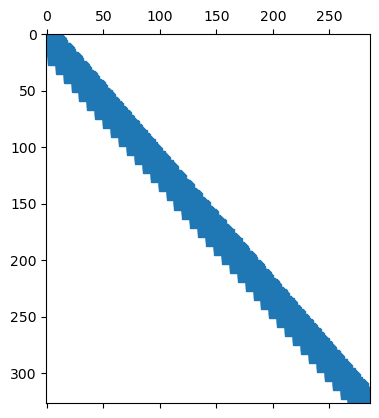

In [16]:
plt.figure()
plt.spy(sol.value(jacobian(opti.g, opti.x)))

In [17]:
print(sol.value(Ps[-1]))
assert_array_almost_equal(
    np.array(sol.value(Ps[-1])),
    [[0.0094851, 0.0073140], 
     [0.0073140, 0.0058025]],
    decimal=7
)

[[0.0094851  0.00731403]
 [0.00731403 0.00580253]]


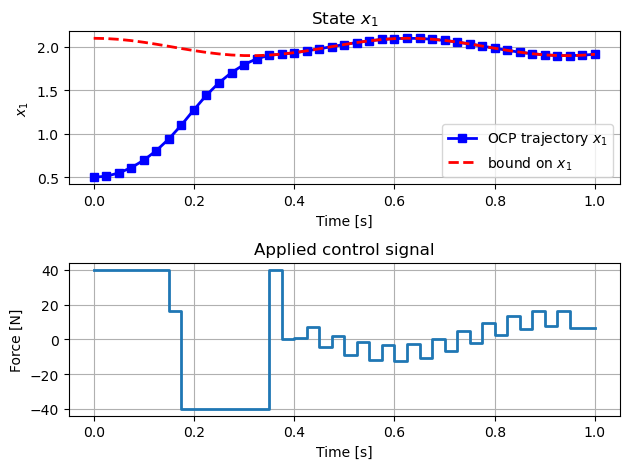

In [18]:
usol = sol.value(U)
xsol = sol.value(X)
make_ioplot(tgrid, xsol, usol)
plt.tight_layout()
filename = "robust_sol_1_1_1_ioplot.pdf"
plt.savefig(os.path.join(plot_dir, filename))
plt.show()